In [6]:
import os
import sys
sys.path.append('..')
import time
import torch
from torch.utils.data import DataLoader
from problems.MCLP.problem_MCLP import MCLP  # Make sure to import from the correct module
from utils import move_to, load_model, torch_load_cpu, get_inner_model  # Import the load_model function from utils
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from IPython.display import display, HTML

# Set max-height to 'none' to prevent scrollbar
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set up the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(platform.python_version())
print(torch.__version__)

3.10.9
2.0.1+cu118


### Helper functions

In [7]:
def create_dataset_from_file(file_path):
    # Load parameters from JSON file
    with open(file_path, 'r') as file:
        params = json.load(file)

    # Extract required parameters for make_dataset function
    n_users = params.get('n_users', 50)
    n_facilities = params.get('n_facilities', 50)
    p = params.get('p', 40)
    r = params.get('r', 0.15)

    # Create dataset instance using MCLP.make_dataset
    random_dataset = MCLP.make_dataset(n_users=n_users, n_facilities=n_facilities, num_samples=1, p=p, r=r)

    # Display the dataset instance or process as needed
    print(random_dataset)
    
    return random_dataset


def plot_points(demand_points, demand_vals, candidate_points, selected_idxes, radius, title=None):
    """
    Plot the demand points, candidate points (CLS), and selected coverage circles.

    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param selected_idxes: List of indexes corresponding to the selected candidate points
    :param radius: Radius for the coverage circles
    :param demand_vals: Array of demand values corresponding to each demand point
    """
    if len(demand_points) != len(demand_vals):
        raise ValueError("The length of demand_points and demand_vals must be the same.")

    plt.figure(figsize=(10, 8))

    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)

    # Plot candidate points
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=30, marker='x')

    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title(
            f"{len(demand_points)} demand units - {len(candidate_points)} CLS - {len(selected_idxes)} selected (r={radius})"
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')
    plt.show()
    
    
def calculate_solution_objective(demand_points, demand_vals, facility_candidate_locations, radius, selected_facility_indexes):
    covered_points = set()  

    for facility_idx in selected_facility_indexes:
        facility = facility_candidate_locations[facility_idx]  

        for i, demand_point in enumerate(demand_points):
            distance = np.linalg.norm(facility - demand_point)  
            if distance <= radius:
                covered_points.add(i)  

    total_demand_covered = sum(demand_vals[i] for i in covered_points)
    # Print the number of covered points
    print(f"Number of covered demand points: {len(covered_points)}")

    return total_demand_covered


def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

## Setup dataset

In [32]:
# 500/200/15/0.15 
#n_users = 2000 # win GA, lose solver
#n_users = 500 # win GA, lose solver
n_users = 4000
n_facilities = 500
p = 20
r = 0.1

random_dataset = MCLP.make_dataset(None, n_users, n_facilities, 1, 0, p, r, None)

# Generate a random dataset
#random_dataset = create_dataset_from_file('outputs/MCLP-200-100-15/args.json')

# Use DataLoader to load the dataset
random_dataloader = DataLoader(random_dataset, batch_size=1)

# get the first batch
batch = next(iter(random_dataloader))
batch = move_to(batch, device)

demand_pts = batch['users'].squeeze(0).cpu().numpy()  # (n_users, 2)
demand_vals = batch['demand'].squeeze(0).cpu().numpy() 
cls = batch['facilities'].squeeze(0).cpu().numpy()  # (n_facilities, 2)

### Greedy Select baseline

Number of covered demand points: 2600
[14323.33]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_9496\329432440.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


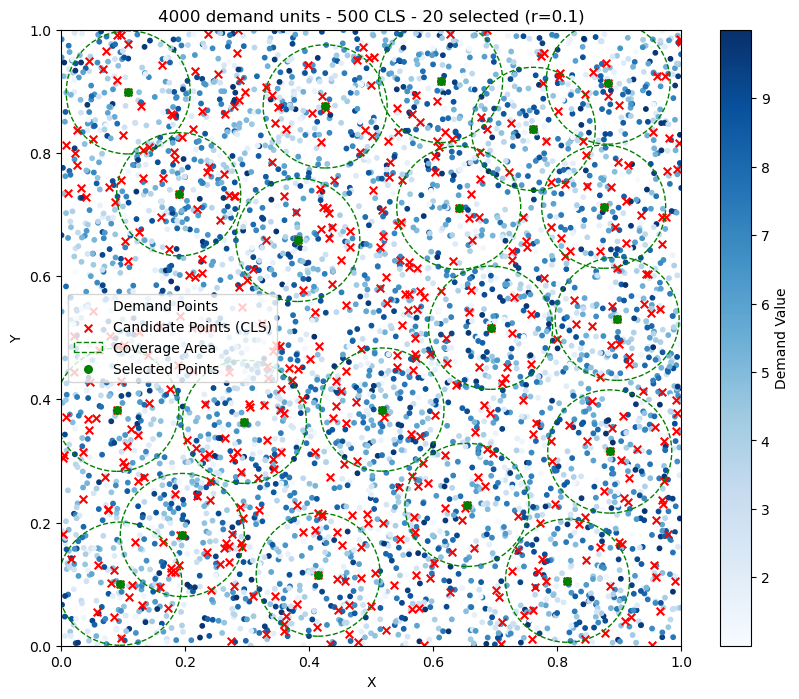

In [33]:
def calculate_covered(demand_points, candidate, radius):
    """
    Calculate which demand points are covered by the given candidate point.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate: Candidate point coordinates (x, y)
    :param radius: Coverage radius
    :return: Array of covered demand points
    """
    distances = np.linalg.norm(demand_points - candidate, axis=1)
    return demand_points[distances <= radius]

def greedy_select_facilities(demand_points, candidate_points, coverage_radius, p):
    """
    Select p facilities that maximize coverage of demand points.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param p: Number of facilities to select
    :return: Indices of the selected facilities
    """
    selected_facilities = []
    remaining_demand_points = demand_points.copy()

    for _ in range(p):
        best_candidate = None
        max_covered = -1
        best_index = -1
        
        # Iterate over all candidate points to find the one that covers the most demand points
        for i, candidate in enumerate(candidate_points):
            covered_points = calculate_covered(remaining_demand_points, candidate, coverage_radius)
            if len(covered_points) > max_covered:
                max_covered = len(covered_points)
                best_candidate = candidate
                best_index = i

        # Add the best candidate to the selected facilities
        selected_facilities.append(best_index)
        
        # Remove the covered demand points from the remaining ones
        remaining_demand_points = np.array([pt for pt in remaining_demand_points 
                                            if np.linalg.norm(pt - best_candidate) > coverage_radius])
        
        # Stop if there are no more demand points to cover
        if len(remaining_demand_points) == 0:
            break

    return selected_facilities


greedy_selected_indices = greedy_select_facilities(demand_pts, cls, r, p)

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, greedy_selected_indices)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, greedy_selected_indices, r)

## DRL model

In [34]:
model_path = '../outputs/MCLP/1000_100_20_20241006T130107/epoch-199.pt'  
model, opts = load_model(model_path)  

  [*] Loading model from ../outputs/MCLP/1000_100_20_20241006T130107/epoch-199.pt


In [62]:
start = time.time()
results = []

num_sample = 1
opts['eval_batch_size'] = 1
opts['max_calc_batch_size'] = 1280000

model.to(device)  # Move the model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode
model.set_decode_type("sampling")
opts['decode_strategy'] = 'sampling'
width = 128 if opts['decode_strategy'] == 'sampling' else 0

with torch.no_grad():
    if opts['decode_strategy'] in ('sampling', 'greedy'):
        if opts['decode_strategy'] == 'greedy':
            assert width == 0, "Do not set width when using greedy"
            assert opts["eval_batch_size"] <= opts["max_calc_batch_size"], \
                "eval_batch_size should be smaller than calc batch size"
            batch_rep = 1
            iter_rep = 1
        elif width * opts["eval_batch_size"] > opts["max_calc_batch_size"]:
            assert opts["eval_batch_size"] == 1
            assert width % opts["max_calc_batch_size"] == 0
            batch_rep = opts["max_calc_batch_size"]
            iter_rep = width // opts["max_calc_batch_size"]
        else:
            batch_rep = width
            iter_rep = 1
        assert batch_rep > 0
        
        # 模型采样
        sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
        batch_size = len(costs)
        ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)

        if sequences is None:
            sequences = [None] * batch_size
            costs = [math.inf] * batch_size
        else:
            sequences, costs = get_best(
                sequences.cpu().numpy(), costs.cpu().numpy(),
                ids.cpu().numpy() if ids is not None else None,
                batch_size
            )
        duration = time.time() - start
        for seq, cost in zip(sequences, costs):
            seq = seq.tolist()
            results.append((cost, seq, duration))
            
# 结果输出
costs, tours, durations = zip(*results)
print(f"The objective of MCBLP by DRL is: {-costs[0]}")
print(tours[0])
end = time.time() - start
print(f"The running time of DRL is: {end}")

The objective of MCBLP by DRL is: 13844.947265625
[156, 218, 115, 474, 250, 454, 475, 445, 60, 15, 102, 493, 57, 75, 339, 461, 428, 213, 239, 124]
The running time of DRL is: 0.09977602958679199


Number of covered demand points: 2499
[13844.956]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_9496\329432440.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


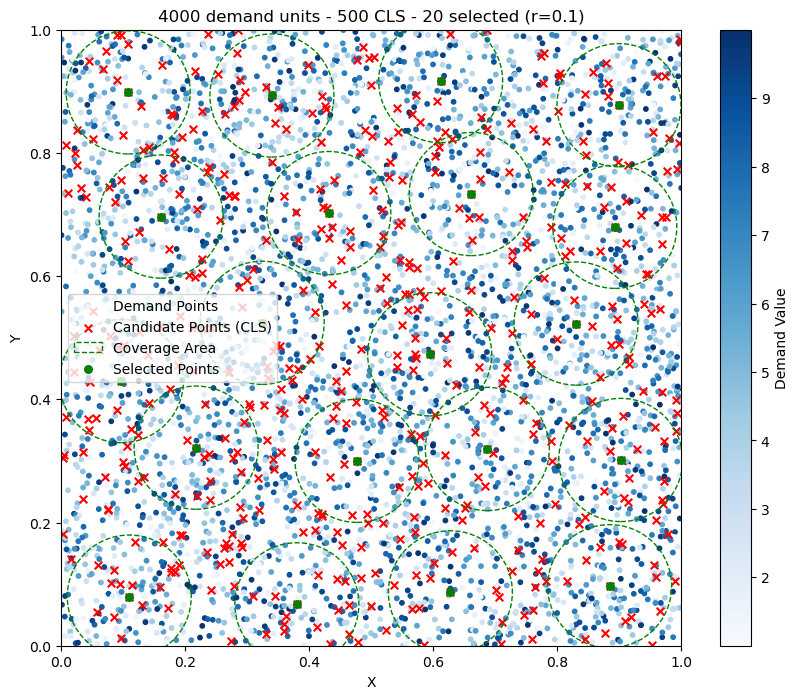

In [63]:
obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, tours[0])
print(obj_val)

plot_points(demand_pts, demand_vals, cls, tours[0], r)

### Eval method (archived)

Running time: 0.0366 seconds
objective val: 3309.7236328125
log-likelihood: -19.254003524780273
selected facility indexes: [[73, 95, 54, 68, 13, 79, 46, 99, 2, 51, 47, 69, 30, 67, 98, 29, 63, 96, 64, 85]]
Number of covered demand points: 612
[3309.7239]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_58600\329432440.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


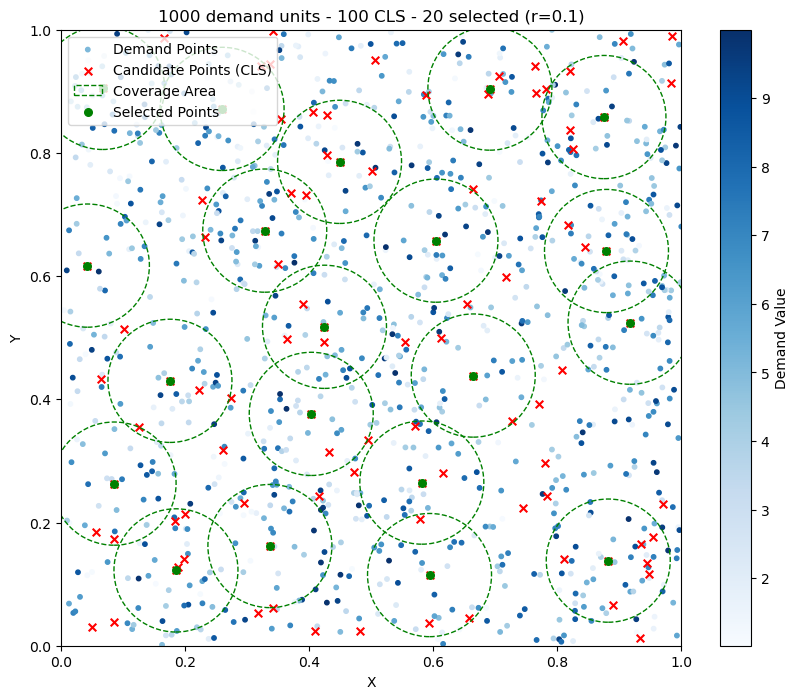

In [81]:
model.to(device)  # Move the model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode
model.set_decode_type("sampling")
#model.set_decode_type("greedy")

with torch.no_grad():
    start_time = time.time()
    cost, ll, selected_facilities = model(batch, return_pi=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Running time: {elapsed_time:.4f} seconds")
    print("objective val:", -cost.item())
    print("log-likelihood:", ll.item())
    print("selected facility indexes:", selected_facilities.tolist())


selected_indices = selected_facilities.squeeze(0).cpu().numpy()  # selected

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, selected_indices)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, selected_indices, r)

## Heuristic - GA approach

Current top solution: [256, 185, 67, 297, 493, 50, 48, 254, 28, 330, 304, 446, 352, 192, 473, 470, 281, 245, 369, 379] f=10762

Final top solution: [76, 75, 231, 319, 10, 155, 153, 492, 438, 37, 425, 86, 161, 260, 208, 38, 267, 434, 217, 200] f=8761
Time: 00:00:1.8050
Number of covered demand points: 2405
[13392.099]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_9496\329432440.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


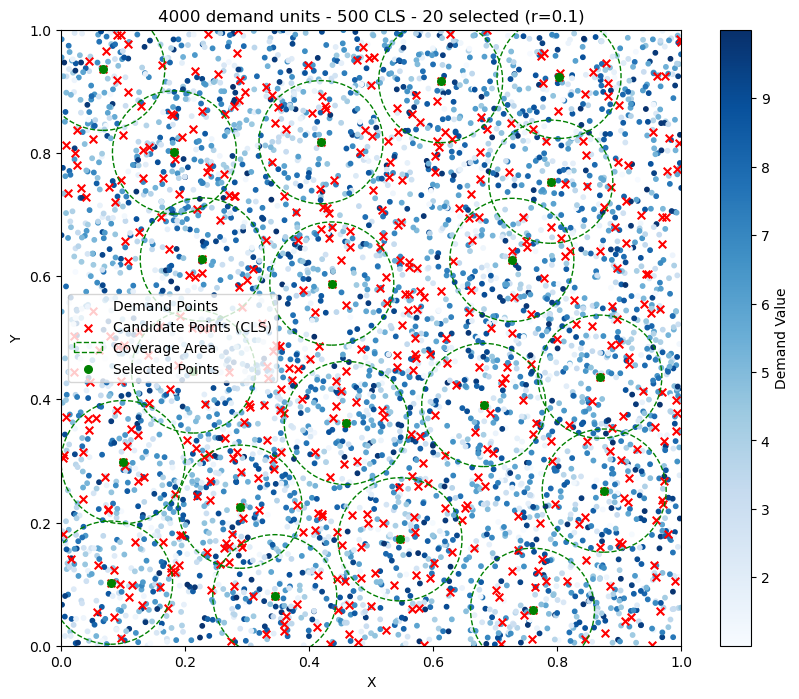

In [40]:
from algorithms.GA import GeneticAlgorithm

# Calculate the distance matrix (Euclidean distance between facilities and demand points)
distance = np.sqrt(np.sum((cls[:, np.newaxis, :] - demand_pts[np.newaxis, :, :]) ** 2, axis=-1))

# Instantiate the genetic algorithm with the necessary parameters
genetic = GeneticAlgorithm(len(demand_pts), len(cls), p, distance, r, demand_vals)

# Run the optimization process
genetic.optimize()

# Get the result (selected centers and the objective value)
obj = np.sum(demand_vals) - genetic.top_chromosome.fitness.item()  # Ensure fitness is a scalar
ga_solution = genetic.top_chromosome.content

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, ga_solution)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, ga_solution, r)

## CPlex solver

In [41]:
from docplex.mp.model import Model

def solve_mclp_cplex(demand_pts, demand_vals, facility_candidate_locations, radius, max_num_selection):
    """
    Solves the Maximal Covering Location Problem using CPLEX.
    """
    num_demand_pts = len(demand_pts)
    num_facilities = len(facility_candidate_locations)
    
    # Create a CPLEX model
    mdl = Model(name="MCLP")

    # Decision variables
    x = mdl.binary_var_list(num_facilities, name="x")  # Facility selection variables
    y = mdl.binary_var_list(num_demand_pts, name="y")  # Demand point coverage variables

    # Calculate coverage: which facilities can cover which demand points
    coverage = []
    for i, demand_pt in enumerate(demand_pts):
        facilities_covering_i = []
        for j, facility in enumerate(facility_candidate_locations):
            # Calculate Euclidean distance between demand point and facility
            if np.linalg.norm(np.array(facility) - np.array(demand_pt)) <= radius:
                facilities_covering_i.append(j)
        coverage.append(facilities_covering_i)
    
    # Objective: maximize the total demand covered
    mdl.maximize(mdl.sum(demand_vals[i].item() * y[i] for i in range(num_demand_pts)))

    # Constraints
    # Each demand point i can only be covered if at least one facility that covers it is selected
    for i in range(num_demand_pts):
        mdl.add_constraint(y[i] <= mdl.sum(x[j] for j in coverage[i]))

    # At most max_num_selection facilities can be selected
    mdl.add_constraint(mdl.sum(x[j] for j in range(num_facilities)) <= max_num_selection)

    # Solve the model
    solution = mdl.solve(log_output=True)
    
    if solution:
        print("Objective Value (Total Demand Covered):", solution.objective_value)
        selected_facilities = [j for j in range(num_facilities) if x[j].solution_value > 0.5]
        print("Selected facility indexes:", selected_facilities)
        return selected_facilities
    else:
        print("No solution found.")
        return None

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1079 rows and 2 columns.
Reduced MIP has 2922 rows, 3419 columns, and 47114 nonzeros.
Reduced MIP has 3419 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (23.60 ticks)
Probing time = 0.00 sec. (0.52 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 3 rows and 0 columns.
Reduced MIP has 2919 rows, 3416 columns, and 47064 nonzeros.
Reduced MIP has 3416 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (18.36 ticks)
Probing time = 0.00 sec. (0.52 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.30 sec. (469.41 ticks)

        Nodes                                     

C:\Users\yzhon\AppData\Local\Temp\ipykernel_9496\329432440.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


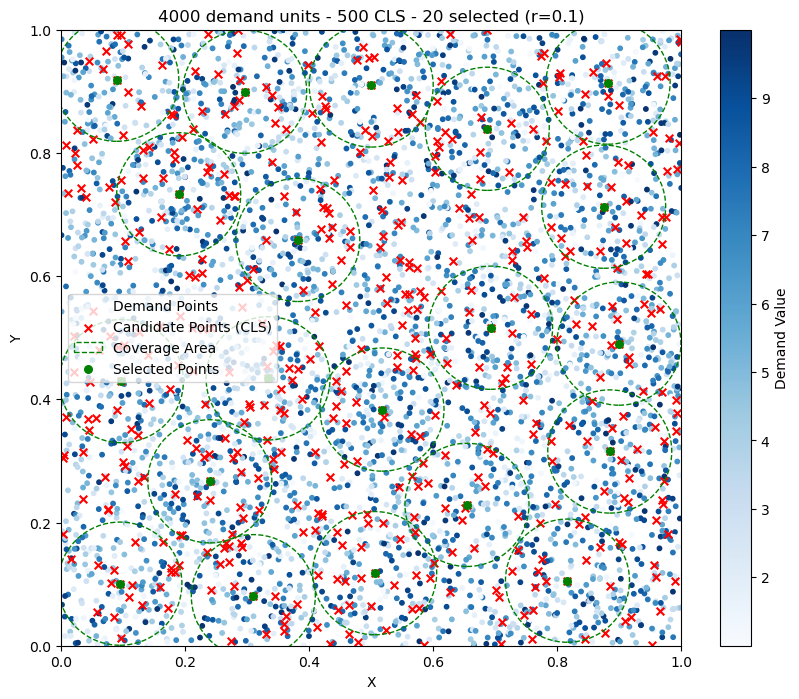

In [42]:
# Solve the problem using the genetic algorithm
cplex_solution = solve_mclp_cplex(demand_pts, demand_vals, cls, r, p)

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, cplex_solution)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, cplex_solution, r)